In [ ]:
!pip install pandas
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install statsmodels
!pip install prophet
!pip install scikit-learn
!pip install plotly
!pip install neuralprophet[live]

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import pandas as pd
import numpy as np
from itertools import product
import datetime
from scipy import interpolate
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from pylab import rcParams
import seaborn as sns
import statsmodels.api as sm
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import math
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from neuralprophet import NeuralProphet

plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False

### 데이터 불러오기

In [2]:
# 학습 데이터
data_tr = pd.read_csv('./t1_data_city/data_tr_city.csv')
data_tr

,datetime,구미 혁신도시배수지 유출유량 적산차
0,2017-01-01 01:00:00,138.0
1,2017-01-01 02:00:00,237.0
2,2017-01-01 03:00:00,128.0
3,2017-01-01 04:00:00,14.0
4,2017-01-01 05:00:00,11.0
...,...,...
35058,2020-12-31 19:00:00,328.0
35059,2020-12-31 20:00:00,347.0
35060,2020-12-31 21:00:00,335.0
35061,2020-12-31 22:00:00,141.0


In [3]:
# 평가 데이터
data_ts = pd.read_csv('./t1_data_city/data_ts_city.csv')
data_ts

,datetime,구미 혁신도시배수지 유출유량 적산차
0,2021-01-01 00:00:00,106.0
1,2021-01-01 01:00:00,184.0
2,2021-01-01 02:00:00,277.0
3,2021-01-01 03:00:00,197.0
4,2021-01-01 04:00:00,72.0
...,...,...
8419,2021-12-17 19:00:00,327.0
8420,2021-12-17 20:00:00,513.0
8421,2021-12-17 21:00:00,396.0
8422,2021-12-17 22:00:00,350.0


In [4]:
# 제출 양식
data_sample = pd.read_csv('./t1_data_city/sample_city.csv')
data_sample

,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
0,2021-01-01 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 03:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 04:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2021-12-17 20:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8421,2021-12-17 21:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8422,2021-12-17 22:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8423,2021-12-17 23:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 복잡한 컬럼명 변경

In [5]:
data_tr.rename(columns= {'구미 혁신도시배수지 유출유량 적산차':'적산차'}, inplace=True)
data_ts.rename(columns= {'구미 혁신도시배수지 유출유량 적산차':'적산차'}, inplace=True)
data_tr.head()

,datetime,적산차
0,2017-01-01 01:00:00,138.0
1,2017-01-01 02:00:00,237.0
2,2017-01-01 03:00:00,128.0
3,2017-01-01 04:00:00,14.0
4,2017-01-01 05:00:00,11.0


### 결측치 확인

In [6]:
data_tr[data_tr.적산차.isnull()]

,datetime,적산차
1748,2017-03-14 21:00:00,NaN
1982,2017-03-24 15:00:00,NaN
12716,2018-06-14 21:00:00,NaN
12717,2018-06-14 22:00:00,NaN
13187,2018-07-04 12:00:00,NaN
13234,2018-07-06 11:00:00,NaN
27253,2020-02-10 14:00:00,NaN
27254,2020-02-10 15:00:00,NaN


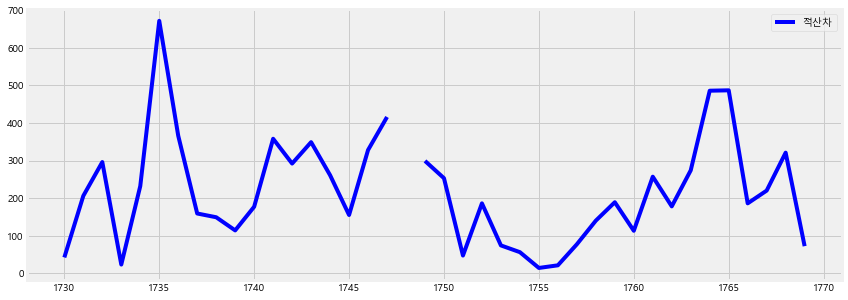

In [7]:
# 결측치 중 한 곳을 시각화
rcParams['figure.figsize'] = 13, 5
data_tr[1730:1770].plot(c='blue')
plt.show()

In [8]:
# linear 보간을 통해 결측치 처리
data_tr_interpolate = data_tr.interpolate(method = 'linear')

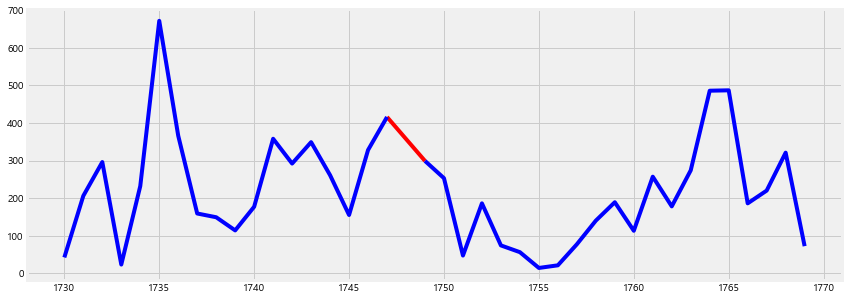

In [9]:
# 보간 후 데이터 시각화
data_tr_interpolate[1747:1750].적산차.plot(c='red')
data_tr[1730:1770].적산차.plot(c='blue')
plt.show()

data_tr = data_tr_interpolate

### 이상치 변환

#### 이상치 제거

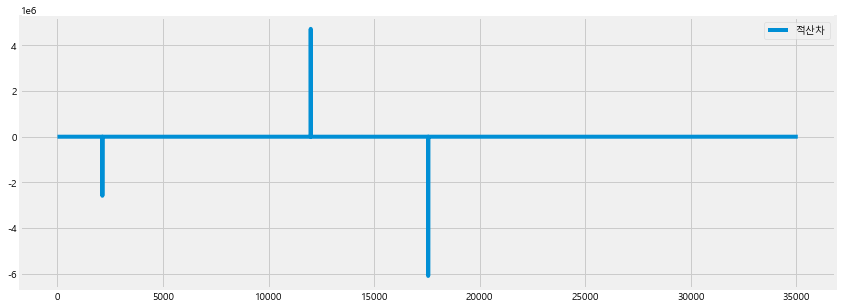

In [10]:
rcParams['figure.figsize'] = 13, 5
data_tr.plot()
plt.show()

In [11]:
index = data_tr[data_tr.적산차 == max(data_tr.적산차)].index
print(index)
data_tr.적산차[index] = np.NaN

Int64Index([11995], dtype='int64')


In [12]:
index = data_tr[data_tr.적산차 == min(data_tr.적산차)].index
print(index)
data_tr.적산차[index] = np.NaN

Int64Index([17558], dtype='int64')


In [13]:
index = data_tr[data_tr.적산차 == min(data_tr.적산차)].index
print(index)
data_tr.적산차[index] = np.NaN

Int64Index([2127], dtype='int64')


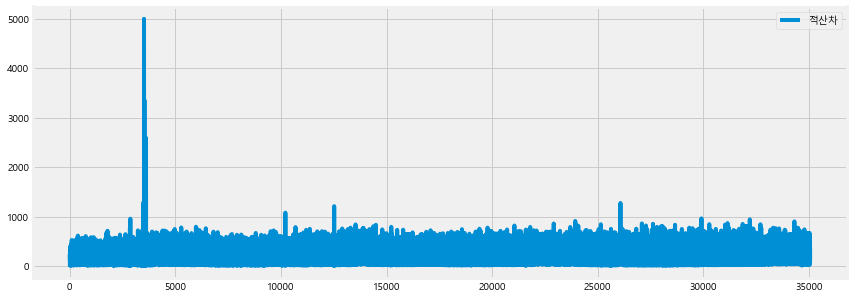

In [14]:
data_tr.plot()
plt.show()

In [15]:
# linear 보간을 통해 결측치 처리
data_tr_interpolate = data_tr.interpolate(method = 'linear')
data_tr = data_tr_interpolate

In [16]:
data_tr.reset_index(drop=True, inplace=True)

In [17]:
data_tr['datetime'] = pd.to_datetime(data_tr['datetime'])
data_tr.set_index('datetime', inplace=True)

data_ts['datetime'] = pd.to_datetime(data_ts['datetime'])
data_ts.set_index('datetime', inplace=True)

data_tr

,적산차
datetime,
2017-01-01 01:00:00,138.0
2017-01-01 02:00:00,237.0
2017-01-01 03:00:00,128.0
2017-01-01 04:00:00,14.0
2017-01-01 05:00:00,11.0
...,...
2020-12-31 19:00:00,328.0
2020-12-31 20:00:00,347.0
2020-12-31 21:00:00,335.0


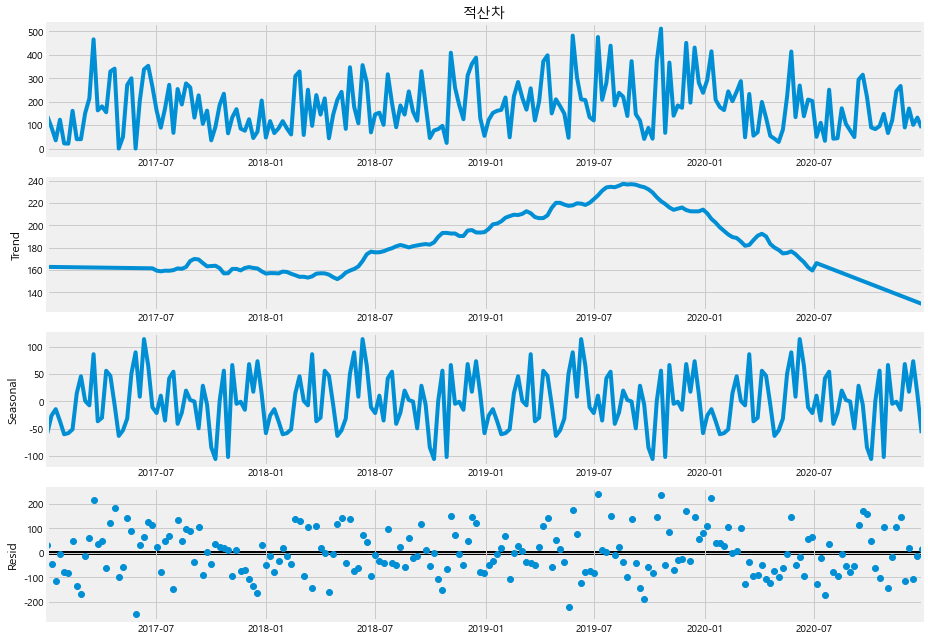

In [18]:
rcParams['figure.figsize'] = 13, 9
decomposed_df_volume = sm.tsa.seasonal_decompose(data_tr['적산차'].asfreq('W'), extrapolate_trend='freq', period=52) # py3.6 이하는 freq=52 가능
figure = decomposed_df_volume.plot()
plt.show()

* 1년의 계절성을 지녔음

In [19]:
meanperhour = []

for i in tqdm(range(24)):
    ytemp = []
    for j in range(len(data_tr)):
        hour = int(str(data_tr.index[j]).split()[1][:2])
        if i == j:
            ytemp.append(data_tr.적산차[i])
    meanperhour.append(np.mean(ytemp))
print(meanperhour)

100%|██████████| 24/24 [00:06<00:00,  3.89it/s]

[138.0, 237.0, 128.0, 14.0, 11.0, 10.0, 11.0, 187.0, 392.0, 114.0, 243.0, 203.0, 250.0, 181.0, 141.0, 148.0, 132.0, 199.0, 202.0, 245.0, 308.0, 152.0, 197.0, 175.0]


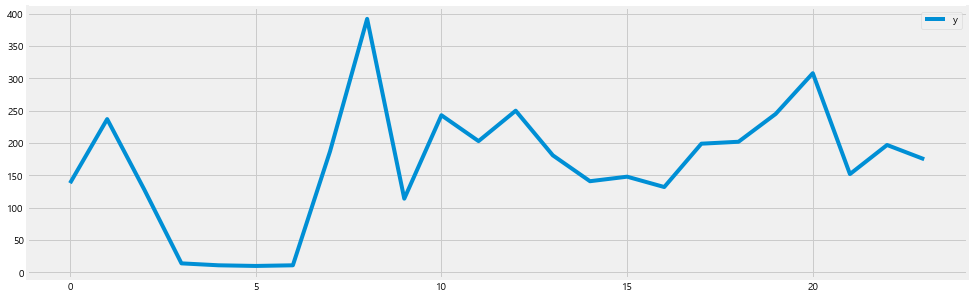

In [20]:
rcParams['figure.figsize'] = 15, 5
pd.DataFrame({'y':meanperhour}).plot()
plt.show()

## Neural Prophet

* 스탠포드 대학교와 메타가 PyTorch를 활용하여 개발하여 기존 prophet 모델에서 개선된 딥러닝 모델

In [21]:
data_tr_prophet = data_tr.copy()
data_tr_prophet.rename(columns= {'적산차':'y'}, inplace=True)
data_tr_prophet['ds'] = data_tr_prophet.index
data_tr_prophet.reset_index(drop=True, inplace=True)

data_ts_prophet = data_ts.copy()
data_ts_prophet.rename(columns= {'적산차':'y'}, inplace=True)
data_ts_prophet['ds'] = data_ts_prophet.index
data_ts_prophet.reset_index(drop=True, inplace=True)

In [273]:
'''
yearly_seasonality = [5, 10, 20]
weekly_seasonality = [5, 10, 20]
daily_seasonality = [5, 10, 20]
num_hidden_layers = [2, 4, 8]
d_hidden = [48, 128, 256, 512]

nprophet_params = [(x[0], x[1], x[2], x[3], x[4]) 
                   for x in list(product(yearly_seasonality,
                                weekly_seasonality,
                                daily_seasonality,
                                num_hidden_layers,
                                d_hidden
                                ))]

best_mae, cnt = '', 0

for ys, ws, ds, nhl, dh in tqdm(nprophet_params):
    m = NeuralProphet(
        seasonality_mode='multiplicative',
        changepoints_range=0.95,
        #growth='decontinuous', #off, leaner, decontinuous
        yearly_seasonality=ys,
        weekly_seasonality=ws,
        daily_seasonality=ds,
        #n_changepoints=nc,
        #seasonality_reg=sr,
        #ar_reg=ar,
        #trend_reg=tr,
        num_hidden_layers=nhl, # 은닉층 수
        d_hidden=dh, # 은닉층 차원 수
        learning_rate=0.1,
        epoch=100
    )    
    
    metrics = m.fit(data_tr_prophet, freq='H')

    forecast = m.predict(data_ts_prophet)
    mae = mean_absolute_error(forecast['y'], forecast['yhat1'])
    
    if cnt == 0:
        cnt += 1
        best_mae = mae
        
    if best_mae > mae:
        best_mae = mae
        best_param = [ys, ws, ds, nhl, dh]
    
    clear_output()
    
    print(f'ys={ys}, ws={ws}, ds={ds}, nc={nc}, nhl={nhl}, dh={dh}, mae={mae}, best mae={best_mae}')
'''

  1%|          | 5/960 [05:42<18:10:14, 68.50s/it]INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.997% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


ys=False, ws=False, ds=False, nc=10, nhl=2, dh=512, mae=140.0707016190459, best mae=140.06986679084395


INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64

Epoch[21/100]:  20%|██        | 20/100 [00:14<00:53,  1.50it/s, SmoothL1Loss=0.0476, MAE=133, RMSE=164, Loss=0.0365, RegLoss=0]


  1%|          | 5/960 [06:06<19:25:25, 73.22s/it]

KeyboardInterrupt



* 직전 일(n_lags=24)을 참고하기에는 주간 패턴이 존재하므로 어려움. 최소 일주일, 년단위의 패턴을 적용시키는 것이 좋아보임
* 2주전 4주전 등등으로 해보는것도?

In [367]:
m = NeuralProphet(
    n_lags=24*7,
    n_forecasts=24*7,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    trend_reg=True,
)    

metrics = m.fit(data_tr_prophet, freq='H')

forecast = m.predict(pd.concat([data_tr_prophet[len(data_tr_prophet)-24*7:], data_ts_prophet], ignore_index=True))
mae = mean_absolute_error(forecast['y'][24*7:], forecast['yhat1'][24*7:])

print(mae)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


86.11199526727935


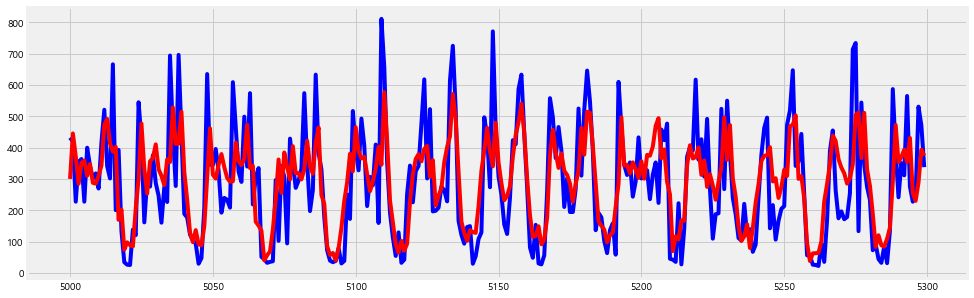

In [369]:
forecast[5000:5300].y.plot(c='blue')
forecast[5000:5300].yhat1.plot(c='red')
plt.show()

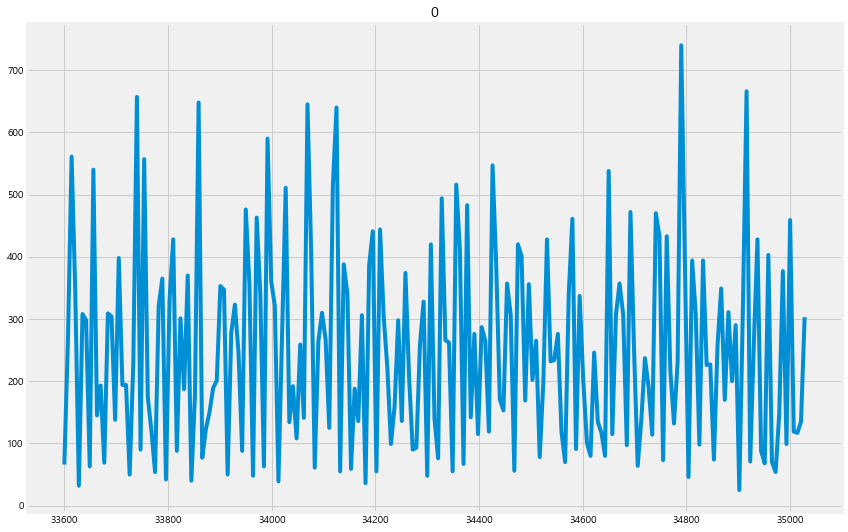

In [89]:
for i in range(24):
    idx = np.arange(i, 35029, 7) + np.array([i]*len(np.arange(i, 35029, 7)))
    data_tr_prophet.iloc[idx][4800:].y.plot()
    plt.title(i)
    plt.show()

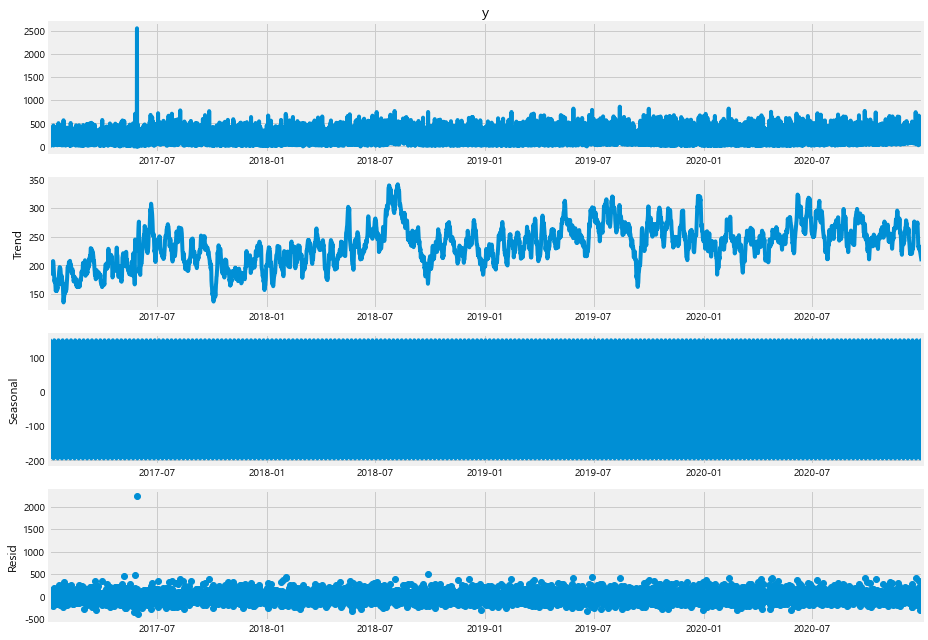

In [92]:
rcParams['figure.figsize'] = 13, 9
decomposed_df_volume = sm.tsa.seasonal_decompose(data_tr_prophet.set_index('ds').iloc[idx].y[1000:2000], extrapolate_trend='freq') # py3.6 이하는 freq=52 가능
figure = decomposed_df_volume.plot()
plt.show()

* 일주일의 주기성을 지닌 듯

#### 매 시간(24시간)대별로 학습을 진행 = 24개 모델 생성

In [334]:
yearly_seasonality = [True] # [5, 10, 15]
weekly_seasonality = [True] # [5, 10, 15]
num_hidden_layers = [4] # [2, 4, 8]
d_hidden = [256] # [32, 64, 128, 256, 512]

nprophet_params = [(x[0], x[1], x[2], x[3]) 
                   for x in list(product(
                                yearly_seasonality,
                                weekly_seasonality,
                                num_hidden_layers,
                                d_hidden
                                ))]

best_param_per_hour = []
best_mae_per_hour = []

for i in tqdm(range(24)):
    
    df = pd.DataFrame({'ds':[], 'y':[]})
    df2 = pd.DataFrame({'ds':[], 'y':[]})
    
    for j in range(len(data_tr_prophet)):
        if i == int(str(data_tr_prophet.ds[j]).split()[1].split(':')[0]):
            df.loc[len(df)] = [data_tr_prophet.ds[j], data_tr_prophet.y[j]]
            
    for j in range(len(data_ts_prophet)):
        if i == int(str(data_ts_prophet.ds[j]).split()[1].split(':')[0]):
            df2.loc[len(df2)] = [data_ts_prophet.ds[j], data_ts_prophet.y[j]]
    
    best_mae, cnt = '', 0
    
    for ys, ws, nhl, dh in tqdm(nprophet_params):
        '''
        m = NeuralProphet(
            seasonality_mode=sm,
            changepoints_range=0.95,
            #growth='decontinuous', #off, leaner, decontinuous
            yearly_seasonality=ys,
            weekly_seasonality=ws,
            #n_changepoints=nc,
            #seasonality_reg=sr,
            #ar_reg=ar,
            #trend_reg=tr,
            num_hidden_layers=nhl, # 은닉층 수
            d_hidden=dh, # 은닉층 차원 수
            learning_rate=0.1,
        )    
        '''
        m = NeuralProphet(
            yearly_seasonality=False,
            weekly_seasonality=True,
            trend_reg=100, # trend가 낮으면 changepoint 변경이 빨라짐
            
        )
        
        metrics = m.fit(df, freq='H')
        forecast = m.predict(df2)
        mae = mean_absolute_error(forecast['y'], forecast['yhat1'])

        if cnt == 0:
            cnt += 1
            best_mae = mae

        if best_mae > mae:
            best_mae = mae
            best_param = [ys, ws, nhl, dh]

        clear_output()
        print(f'{i} : ys={ys}, ws={ws}, nhl={nhl}, dh={dh}, mae={mae}, best mae={best_mae}')
        
    best_param_per_hour.append(best_param)
    best_mae_per_hour.append(best_mae)
    
clear_output()    
for i, mae in enumerate(best_mae_per_hour):
    print(f'{i} : best_param={best_param_per_hour[i]} best mae={mae}')
np.mean(best_mae_per_hour)


 12%|█▎        | 3/24 [00:41<04:49, 13.78s/it]

2 : ys=True, ws=True, nhl=4, dh=256, mae=51.090885325374764, best mae=51.090885325374764



  0%|          | 0/1 [00:00<?, ?it/s]INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency H is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 173


  0%|          | 0/129 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.41E+00, min: 6.85E-02


  0%|          | 0/129 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.61E-01, min: 6.85E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.42E-01


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch[1/173]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch[1/173]:   0%|          | 0/173 [00:00<?, ?it/s, SmoothL1Loss=0.909, MAE=273, RMSE=308, Loss=0.642, RegLoss=0]

Epoch[2/173]:   0%|          | 0/173 [00:00<?, ?it/s, SmoothL1Loss=0.909, MAE=273, RMSE=308, Loss=0.642, RegLoss=0]

Epoch[2/173]:   0%|          | 0/173 [00:00<?, ?it/s, SmoothL1Loss=0.448, MAE=169, RMSE=205, Loss=0.285, RegLoss=0]

Epoch[2/173]:   1%|          | 2/173 [00:00<00:10, 16.26it/s, SmoothL1Loss=0.448, MAE=169, RMSE=205, Loss=0.285, RegLoss=0]

Epoch[3/173]:   1%|          | 2/173 [00:00<00:10, 16.26it/s, SmoothL1Loss=0.448, MAE=169, RMSE=205, Loss=0.285, RegLoss=0]

Epoch[3/173]:   1%|          | 2/173 [00:00<00:10, 16.26it/s, SmoothL1Loss=0.331, MAE=141, RMSE=173, Loss=0.205, Reg

Epoch[24/173]:  14%|█▍        | 24/173 [00:01<00:09, 16.13it/s, SmoothL1Loss=0.0661, MAE=54.1, RMSE=75.1, Loss=0.048, RegLoss=0]

Epoch[25/173]:  14%|█▍        | 24/173 [00:01<00:09, 16.13it/s, SmoothL1Loss=0.0661, MAE=54.1, RMSE=75.1, Loss=0.048, RegLoss=0]

Epoch[25/173]:  14%|█▍        | 24/173 [00:01<00:09, 16.13it/s, SmoothL1Loss=0.0835, MAE=61.9, RMSE=84.7, Loss=0.0618, RegLoss=0]

Epoch[26/173]:  14%|█▍        | 24/173 [00:01<00:09, 16.13it/s, SmoothL1Loss=0.0835, MAE=61.9, RMSE=84.7, Loss=0.0618, RegLoss=0]

Epoch[26/173]:  14%|█▍        | 24/173 [00:01<00:09, 16.13it/s, SmoothL1Loss=0.0808, MAE=62.5, RMSE=83.8, Loss=0.0598, RegLoss=0]

Epoch[26/173]:  15%|█▌        | 26/173 [00:01<00:09, 16.17it/s, SmoothL1Loss=0.0808, MAE=62.5, RMSE=83.8, Loss=0.0598, RegLoss=0]

Epoch[27/173]:  15%|█▌        | 26/173 [00:01<00:09, 16.17it/s, SmoothL1Loss=0.0808, MAE=62.5, RMSE=83.8, Loss=0.0598, RegLoss=0]

Epoch[27/173]:  15%|█▌        | 26/173 [00:01<00:09, 16.17it/s, SmoothL1Loss=0.0734, 

Epoch[48/173]:  28%|██▊       | 48/173 [00:02<00:07, 16.16it/s, SmoothL1Loss=0.168, MAE=92.1, RMSE=120, Loss=0.131, RegLoss=0]

Epoch[49/173]:  28%|██▊       | 48/173 [00:03<00:07, 16.16it/s, SmoothL1Loss=0.168, MAE=92.1, RMSE=120, Loss=0.131, RegLoss=0]

Epoch[49/173]:  28%|██▊       | 48/173 [00:03<00:07, 16.16it/s, SmoothL1Loss=0.178, MAE=94, RMSE=121, Loss=0.143, RegLoss=0]  

Epoch[50/173]:  28%|██▊       | 48/173 [00:03<00:07, 16.16it/s, SmoothL1Loss=0.178, MAE=94, RMSE=121, Loss=0.143, RegLoss=0]

Epoch[50/173]:  28%|██▊       | 48/173 [00:03<00:07, 16.16it/s, SmoothL1Loss=0.0915, MAE=66, RMSE=88.8, Loss=0.0695, RegLoss=0]

Epoch[50/173]:  29%|██▉       | 50/173 [00:03<00:07, 16.15it/s, SmoothL1Loss=0.0915, MAE=66, RMSE=88.8, Loss=0.0695, RegLoss=0]

Epoch[51/173]:  29%|██▉       | 50/173 [00:03<00:07, 16.15it/s, SmoothL1Loss=0.0915, MAE=66, RMSE=88.8, Loss=0.0695, RegLoss=0]

Epoch[51/173]:  29%|██▉       | 50/173 [00:03<00:07, 16.15it/s, SmoothL1Loss=0.145, MAE=84.7, RMSE=111,

Epoch[72/173]:  42%|████▏     | 72/173 [00:04<00:06, 16.18it/s, SmoothL1Loss=0.0885, MAE=65.4, RMSE=87.6, Loss=0.0666, RegLoss=0]

Epoch[73/173]:  42%|████▏     | 72/173 [00:04<00:06, 16.18it/s, SmoothL1Loss=0.0885, MAE=65.4, RMSE=87.6, Loss=0.0666, RegLoss=0]

Epoch[73/173]:  42%|████▏     | 72/173 [00:04<00:06, 16.18it/s, SmoothL1Loss=0.0883, MAE=64.6, RMSE=87.4, Loss=0.0657, RegLoss=0]

Epoch[74/173]:  42%|████▏     | 72/173 [00:04<00:06, 16.18it/s, SmoothL1Loss=0.0883, MAE=64.6, RMSE=87.4, Loss=0.0657, RegLoss=0]

Epoch[74/173]:  42%|████▏     | 72/173 [00:04<00:06, 16.18it/s, SmoothL1Loss=0.0917, MAE=65.5, RMSE=88.6, Loss=0.0702, RegLoss=0]

Epoch[74/173]:  43%|████▎     | 74/173 [00:04<00:06, 16.20it/s, SmoothL1Loss=0.0917, MAE=65.5, RMSE=88.6, Loss=0.0702, RegLoss=0]

Epoch[75/173]:  43%|████▎     | 74/173 [00:04<00:06, 16.20it/s, SmoothL1Loss=0.0917, MAE=65.5, RMSE=88.6, Loss=0.0702, RegLoss=0]

Epoch[75/173]:  43%|████▎     | 74/173 [00:04<00:06, 16.20it/s, SmoothL1Loss=0.101,

Epoch[96/173]:  55%|█████▌    | 96/173 [00:05<00:04, 16.10it/s, SmoothL1Loss=0.09, MAE=65.4, RMSE=87.6, Loss=0.0679, RegLoss=0]

Epoch[97/173]:  55%|█████▌    | 96/173 [00:05<00:04, 16.10it/s, SmoothL1Loss=0.09, MAE=65.4, RMSE=87.6, Loss=0.0679, RegLoss=0]

Epoch[97/173]:  55%|█████▌    | 96/173 [00:06<00:04, 16.10it/s, SmoothL1Loss=0.087, MAE=64.2, RMSE=86.8, Loss=0.0651, RegLoss=0]

Epoch[98/173]:  55%|█████▌    | 96/173 [00:06<00:04, 16.10it/s, SmoothL1Loss=0.087, MAE=64.2, RMSE=86.8, Loss=0.0651, RegLoss=0]

Epoch[98/173]:  55%|█████▌    | 96/173 [00:06<00:04, 16.10it/s, SmoothL1Loss=0.0793, MAE=60, RMSE=82.2, Loss=0.0606, RegLoss=0] 

Epoch[98/173]:  57%|█████▋    | 98/173 [00:06<00:04, 16.11it/s, SmoothL1Loss=0.0793, MAE=60, RMSE=82.2, Loss=0.0606, RegLoss=0]

Epoch[99/173]:  57%|█████▋    | 98/173 [00:06<00:04, 16.11it/s, SmoothL1Loss=0.0793, MAE=60, RMSE=82.2, Loss=0.0606, RegLoss=0]

Epoch[99/173]:  57%|█████▋    | 98/173 [00:06<00:04, 16.11it/s, SmoothL1Loss=0.0732, MAE=58.2,

Epoch[120/173]:  68%|██████▊   | 118/173 [00:07<00:03, 15.53it/s, SmoothL1Loss=0.0775, MAE=59, RMSE=81.9, Loss=0.0895, RegLoss=0.031]

Epoch[120/173]:  68%|██████▊   | 118/173 [00:07<00:03, 15.53it/s, SmoothL1Loss=0.0683, MAE=56.1, RMSE=76.9, Loss=0.0956, RegLoss=0.0443]

Epoch[120/173]:  69%|██████▉   | 120/173 [00:07<00:03, 15.34it/s, SmoothL1Loss=0.0683, MAE=56.1, RMSE=76.9, Loss=0.0956, RegLoss=0.0443]

Epoch[121/173]:  69%|██████▉   | 120/173 [00:07<00:03, 15.34it/s, SmoothL1Loss=0.0683, MAE=56.1, RMSE=76.9, Loss=0.0956, RegLoss=0.0443]

Epoch[121/173]:  69%|██████▉   | 120/173 [00:07<00:03, 15.34it/s, SmoothL1Loss=0.0646, MAE=54, RMSE=75, Loss=0.104, RegLoss=0.0566]     

Epoch[122/173]:  69%|██████▉   | 120/173 [00:07<00:03, 15.34it/s, SmoothL1Loss=0.0646, MAE=54, RMSE=75, Loss=0.104, RegLoss=0.0566]

Epoch[122/173]:  69%|██████▉   | 120/173 [00:07<00:03, 15.34it/s, SmoothL1Loss=0.0727, MAE=57.7, RMSE=79.3, Loss=0.122, RegLoss=0.0674]

Epoch[122/173]:  71%|███████   | 122/173 [0

Epoch[142/173]:  81%|████████  | 140/173 [00:08<00:02, 14.96it/s, SmoothL1Loss=0.0549, MAE=49.5, RMSE=69.1, Loss=0.0446, RegLoss=0.00486]

Epoch[142/173]:  82%|████████▏ | 142/173 [00:08<00:02, 14.75it/s, SmoothL1Loss=0.0549, MAE=49.5, RMSE=69.1, Loss=0.0446, RegLoss=0.00486]

Epoch[143/173]:  82%|████████▏ | 142/173 [00:08<00:02, 14.75it/s, SmoothL1Loss=0.0549, MAE=49.5, RMSE=69.1, Loss=0.0446, RegLoss=0.00486]

Epoch[143/173]:  82%|████████▏ | 142/173 [00:09<00:02, 14.75it/s, SmoothL1Loss=0.0581, MAE=51.5, RMSE=70.4, Loss=0.0477, RegLoss=0.00544]

Epoch[144/173]:  82%|████████▏ | 142/173 [00:09<00:02, 14.75it/s, SmoothL1Loss=0.0581, MAE=51.5, RMSE=70.4, Loss=0.0477, RegLoss=0.00544]

Epoch[144/173]:  82%|████████▏ | 142/173 [00:09<00:02, 14.75it/s, SmoothL1Loss=0.0569, MAE=50.6, RMSE=69.9, Loss=0.0485, RegLoss=0.00695]

Epoch[144/173]:  83%|████████▎ | 144/173 [00:09<00:01, 14.77it/s, SmoothL1Loss=0.0569, MAE=50.6, RMSE=69.9, Loss=0.0485, RegLoss=0.00695]

Epoch[145/173]:  83%|██████

KeyboardInterrupt: 

In [323]:
for i, mae in enumerate(best_mae_per_hour):
    print(f'{i} : best_param={best_param_per_hour[i]} best mae={mae}')
np.mean(best_mae_per_hour)

0 : best_param=[5, 15, 2, 48] best mae=95.93468938322148
1 : best_param=[5, 15, 2, 48] best mae=79.2313877116581
2 : best_param=[5, 15, 2, 48] best mae=51.071858180554166
3 : best_param=[5, 15, 2, 48] best mae=37.51421084499088
4 : best_param=[5, 15, 2, 48] best mae=29.336077067926738
5 : best_param=[5, 15, 2, 48] best mae=29.639226201592688
6 : best_param=[5, 15, 2, 48] best mae=36.297545082548744
7 : best_param=[5, 15, 2, 48] best mae=57.35594072912493
8 : best_param=[5, 15, 2, 48] best mae=100.96616052698207
9 : best_param=[5, 15, 2, 48] best mae=125.64697448208801
10 : best_param=[5, 15, 2, 48] best mae=114.61342340453058
11 : best_param=[5, 15, 2, 48] best mae=113.08279505889979
12 : best_param=[5, 15, 2, 48] best mae=122.43357305716926
13 : best_param=[5, 15, 2, 48] best mae=111.425049610627
14 : best_param=[5, 15, 2, 48] best mae=113.00580625180845
15 : best_param=[5, 15, 2, 48] best mae=89.67685632080774
16 : best_param=[5, 15, 2, 48] best mae=77.68071357748786
17 : best_param=

91.2812414237237

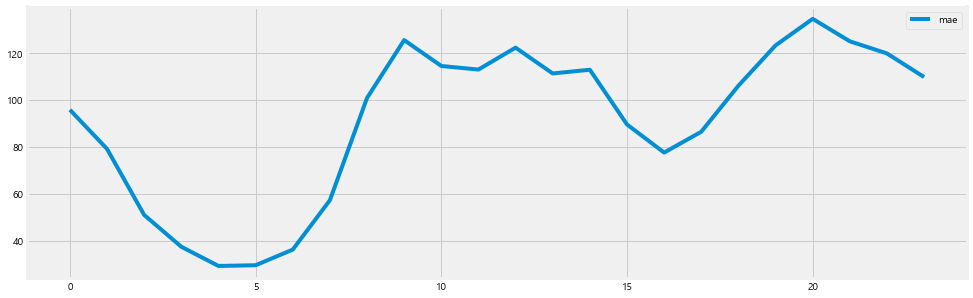

In [324]:
rcParams['figure.figsize'] = 15, 5
pd.DataFrame({'mae':best_mae_per_hour}).set_index(np.arange(0,24)).plot()
plt.show()

* 새벽은 오류가 적지만, 주간에는 오류가 많음

#### 시간별 모델 생성

In [336]:
models = []

for i in tqdm(range(24)):
    df = pd.DataFrame({'ds':[], 'y':[]})
    df2 = pd.DataFrame({'ds':[], 'y':[]})
    for j in range(len(data_tr_prophet)):
        if i == int(str(data_tr_prophet.ds[j]).split()[1].split(':')[0]):
            df.loc[len(df)] = [data_tr_prophet.ds[j], data_tr_prophet.y[j]]
            
    for j in range(len(data_ts_prophet)):
        if i == int(str(data_ts_prophet.ds[j]).split()[1].split(':')[0]):
            df2.loc[len(df2)] = [data_ts_prophet.ds[j], data_ts_prophet.y[j]]
    
    m = NeuralProphet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        trend_reg=100,
        )    

    metrics = m.fit(df, freq='D')
    models.append(m)
    clear_output()

100%|██████████| 24/24 [05:31<00:00, 13.81s/it]


In [ ]:
def update(m, hour, step)
    df = pd.DataFrame({'ds':[], 'y':[]})
    
    for i in range(len(data_tr_prophet)):
        if hour == int(str(data_tr_prophet.ds[i]).split()[1].split(':')[0]):
            df.loc[len(df)] = [data_tr_prophet.ds[i], data_tr_prophet.y[i]]
            
    for i in range(len(data_ts_prophet[:step])):
        if hour == int(str(data_ts_prophet.ds[i]).split()[1].split(':')[0]):
            df.loc[len(df)] = [data_ts_prophet.ds[i], data_ts_prophet.y[i]]
            
    m.fit(df, freq='D')

In [337]:
idx = np.arange(0, 336, 24) 
for i, start in enumerate(tqdm(data_sample.datetime)):
    
    start = pd.to_datetime(start)
    ds = pd.date_range(start, start + datetime.timedelta(hours=335), freq='H')
    future = pd.DataFrame({'ds':ds, 'y':[0]*336})
    
    start_hour = int(str(start).split()[1].split(':')[0])
    #models[start_hour%24] = update(models[start_hour%24], start_hour%24, i)
    
    temp = [np.NaN]*336
    for t, j in enumerate(range(start_hour, start_hour+24)):
        forecast = models[j%24].predict(future.iloc[idx+t])['yhat1']
        for e, k in enumerate(idx+t):
            temp[k] = forecast[e]
    data_sample.loc[i] = [start] + temp
    clear_output()
    
data_sample

100%|██████████| 8425/8425 [1:15:07<00:00,  1.87it/s]


,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
0,2021-01-01 00:00:00,287.478210,209.177872,130.365387,78.907562,59.305511,56.078266,61.955147,105.837997,280.503143,...,338.533508,279.098328,246.322311,253.693054,279.141846,371.808380,465.751862,486.746643,458.445801,390.391327
1,2021-01-01 01:00:00,209.177872,130.365387,78.907562,59.305511,56.078266,61.955147,105.837997,280.503143,396.994995,...,279.098328,246.322311,253.693054,279.141846,371.808380,465.751862,486.746643,458.445801,390.391327,287.484955
2,2021-01-01 02:00:00,130.365387,78.907562,59.305511,56.078266,61.955147,105.837997,280.503143,396.994995,335.778839,...,246.322311,253.693054,279.141846,371.808380,465.751862,486.746643,458.445801,390.391327,287.484955,209.407196
3,2021-01-01 03:00:00,78.907562,59.305511,56.078266,61.955147,105.837997,280.503143,396.994995,335.778839,355.533691,...,253.693054,279.141846,371.808380,465.751862,486.746643,458.445801,390.391327,287.484955,209.407196,130.429306
4,2021-01-01 04:00:00,59.305511,56.078266,61.955147,105.837997,280.503143,396.994995,335.778839,355.533691,372.402710,...,279.141846,371.808380,465.751862,486.746643,458.445801,390.391327,287.484955,209.407196,130.429306,79.019577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2021-12-17 20:00:00,505.130585,480.372162,425.291901,331.171875,254.499786,193.538498,125.062675,89.396065,69.372337,...,349.417969,380.970490,407.205383,381.360107,334.522888,278.026215,241.667114,259.747070,292.913818,400.485992
8421,2021-12-17 21:00:00,480.372162,425.291901,331.171875,254.499786,193.538498,125.062675,89.396065,69.372337,52.487190,...,380.970490,407.205383,381.360107,334.522888,278.026215,241.667114,259.747070,292.913818,400.485992,507.353760
8422,2021-12-17 22:00:00,425.291901,331.171875,254.499786,193.538498,125.062675,89.396065,69.372337,52.487190,56.162083,...,407.205383,381.360107,334.522888,278.026215,241.667114,259.747070,292.913818,400.485992,507.353760,482.411011
8423,2021-12-17 23:00:00,331.171875,254.499786,193.538498,125.062675,89.396065,69.372337,52.487190,56.162083,74.634369,...,381.360107,334.522888,278.026215,241.667114,259.747070,292.913818,400.485992,507.353760,482.411011,426.653442


In [339]:
data_sample.to_csv('./t1_data_city/submission_neuralprophet.csv', index=False)

In [ ]:
지난 2주, 지난 한달 기반으로도
n_lags=6이면 6개를 앞서 더 쓰고 시작하면...? 

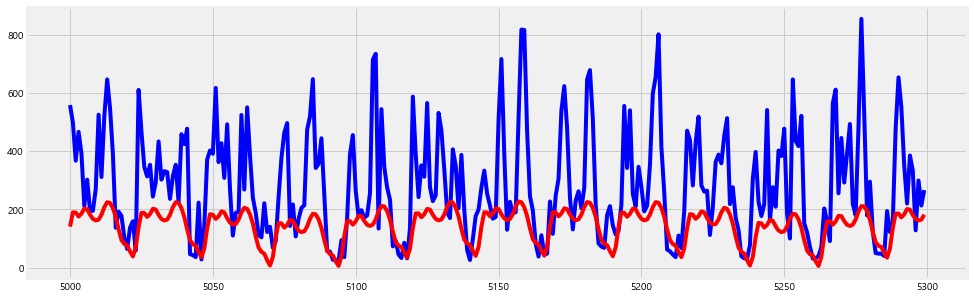

In [370]:
data_ts_prophet.y.plot(c='blue')
data_sample.h0.plot(c='red')

plt.show()

In [385]:
for i, start in enumerate(tqdm(data_sample.datetime)):
    
    if i < 8089:
        continue
    
    start = pd.to_datetime(start)
    ds = pd.date_range(data_sample.datetime[8424] ,start + datetime.timedelta(hours=335), freq='H')

    df = pd.concat([data_tr_prophet[len(data_tr_prophet)-24*7:], data_ts_prophet], ignore_index=True)
    df = pd.concat([df, pd.DataFrame({'ds':ds, 'y':[0]*len(ds)})], ignore_index=True)
#    future = pd.DataFrame({'ds':ds,
#                            'y':[0]*336})
    forecast = m.predict(df[i:336+i+(7*24)])
    data_sample.loc[i] = [start] + list(forecast['yhat1'][24*7:])

    clear_output()
    
data_sample

100%|██████████| 8425/8425 [01:41<00:00, 82.85it/s]   


,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
0,2021-01-01 00:00:00,231.313324,196.993118,205.838959,198.409332,139.421738,71.404243,49.306110,91.967529,162.677353,...,287.987335,172.790817,229.225174,315.030090,307.218323,320.440186,345.096191,411.371368,475.159363,327.976166
1,2021-01-01 01:00:00,196.993118,205.838959,198.409332,139.421738,71.404243,49.306110,91.967529,162.677353,268.574738,...,172.790817,229.225174,315.030090,307.218323,320.440186,345.096191,411.371368,475.159363,327.976166,243.539291
2,2021-01-01 02:00:00,205.838959,198.409332,139.421738,71.404243,49.306110,91.967529,162.677353,268.574738,335.326141,...,229.225174,315.030090,307.218323,320.440186,345.096191,411.371368,475.159363,327.976166,243.539291,163.414474
3,2021-01-01 03:00:00,198.409332,139.421738,71.404243,49.306110,91.967529,162.677353,268.574738,335.326141,335.136749,...,315.030090,307.218323,320.440186,345.096191,411.371368,475.159363,327.976166,243.539230,163.414474,124.409920
4,2021-01-01 04:00:00,139.421738,71.404243,49.306110,91.967529,162.677353,268.574738,335.326141,335.136749,335.798035,...,307.218323,320.440186,345.096191,411.371368,475.159363,327.976166,243.539230,163.414459,124.409920,63.206852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2021-12-17 20:00:00,369.321503,415.245209,331.636261,288.576385,178.865768,97.757462,92.828522,62.415127,65.493896,...,163.871964,149.393692,158.228348,175.119843,171.462036,151.861664,136.416794,129.923767,131.517654,146.835953
8421,2021-12-17 21:00:00,415.245209,331.636261,288.576385,178.865768,97.757462,92.828522,62.415127,65.493896,70.474518,...,149.393692,158.228348,175.119843,171.462036,151.861664,136.416794,129.923767,131.517654,146.835953,171.741592
8422,2021-12-17 22:00:00,331.636261,288.576385,178.865768,97.757462,92.828522,62.415127,65.493896,70.474518,67.131416,...,158.228348,175.119843,171.462036,151.861664,136.416794,129.923767,131.517654,146.835953,171.741592,187.372269
8423,2021-12-17 23:00:00,288.576385,178.865768,97.757462,92.828522,62.415127,65.493896,70.474518,67.131416,136.858368,...,175.119843,171.462036,151.861664,136.416794,129.923767,131.517654,146.835953,171.741592,187.372269,183.373718


In [387]:
data_sample.to_csv('./t1_data_city/submission_neuralprophet.csv', index=False)